In [1]:
import math
import nltk
from nltk.corpus import brown
import re

In [2]:
def process_string(s):
    if re.search(r'[a-zA-Z]', s):
        match = re.search(r'[-+]', s)
        if match:
            s = s[:match.start()]
        if re.search(r'[a-zA-Z]', s):
            s = re.sub(r'[^a-zA-Z]', '', s)
    return s

In [3]:
nltk.download('brown')
threshold = math.floor(len(brown.tagged_sents(categories='news'))*0.9)
corpus = brown.tagged_sents(categories='news')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\nil34\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [4]:
clean_corpus = []
for sentence in corpus:
    lst = []
    for i in range(len(sentence)):
        new_tag = process_string(sentence[i][1])
        new_tuple = (sentence[i][0],new_tag)
        lst.append(new_tuple)
    clean_corpus.append(lst)


In [5]:
training_set = clean_corpus[:threshold]
test_set = clean_corpus[threshold:]


In [6]:
#create a dictionary for the training set words and labels in a format of (word,label):number of times it appeared
words_and_labels_dict = {}

for sentence in training_set:
    for pair in sentence:
        words_and_labels_dict[pair] = words_and_labels_dict.get(pair,0) + 1

In [7]:
#create a dictionary for the training set labels in a format of label:number of times it appeared
labels_dict = {}

for sentence in training_set:
    sentence.append(('','STOP'))
    sentence.reverse()
    sentence.append(('','START'))
    sentence.reverse()

    for pair in sentence:
        labels_dict[pair[1]] = labels_dict.get(pair[1],0) + 1

In [8]:
#create a dictionary for the training set labels in a format of label:number of times it appeared
test_labels_dict = {}

for sentence in test_set:
    for pair in sentence:
        test_labels_dict[pair[1]] = test_labels_dict.get(pair[1],0) + 1

In [9]:
#create a dictionary for the training set labels in a format of word:number of times it appeared
words_dict = {}
for sentence in training_set:
    for pair in sentence:
        word = pair[0]
        words_dict[word] = words_dict.get(word,0) + 1

#create a dictionary for the test set labels in a format of label:number of times it appeared
test_words_dict = {}
for sentence in test_set:
    for pair in sentence:
        word = pair[0]
        test_words_dict[word] = test_words_dict.get(word,0) + 1

## b)

In [10]:
#create a dictionary for the training set words and labels in a format of word:most likely label
all_words = set()
most_likely_tag_per_word = {}

for key in words_and_labels_dict.keys():
    word = key[0]
    if word in all_words:
        continue
    all_words.add(word)

    max_appearences = 0
    most_likely_label = ""

    for pair in words_and_labels_dict.keys():
        label = pair[1]
        pair_word = pair[0]

        if pair_word == word:
            if max_appearences < words_and_labels_dict[pair]:
                max_appearences =  words_and_labels_dict[pair]
                most_likely_label = label

    most_likely_tag_per_word[word] = most_likely_label

In [11]:
#create a dictionary for the test set words and labels in a format of (word,label):number of times appeared
test_words_and_labels_dict = {}
for line in test_set:
    for pair in line:
        test_words_and_labels_dict[pair] = test_words_and_labels_dict.get(pair,0) + 1

In [12]:
#count the number of correct predictions in the test set
known_words = 0
unknown_words = 0
num_of_correct_known_words = 0
num_of_correct_unknown_words = 0

for pair,count in test_words_and_labels_dict.items():
    word = pair[0]
    label = pair[1]
    if word in most_likely_tag_per_word:
        known_words += count
        if label == most_likely_tag_per_word[word]:
            num_of_correct_known_words += count
    else:
        unknown_words += count
        if label == "NN":
            num_of_correct_unknown_words += count

known_words_error_rate = 1-(num_of_correct_known_words/known_words)
unknown_words_error_rate = 1-(num_of_correct_unknown_words/unknown_words)
total_error_rate = 1-((num_of_correct_unknown_words + num_of_correct_known_words)/(known_words+unknown_words))

In [13]:
print("known words error rate:")
print(known_words_error_rate)
print("unknown words error rate:")
print(unknown_words_error_rate)
print("total error rate is: ")
print(total_error_rate)

known words error rate:
0.0704399684933048
unknown words error rate:
0.743455497382199
total error rate is: 
0.14731386424798165


## Section C

In [14]:
#create transition probabilities
labels_transition_probabilities = {}

#count the labels (y_i|y_i-1)
for sentence in training_set:
    for i in range(len(sentence) - 1):
        key = (sentence[i][1],sentence[i+1][1])
        labels_transition_probabilities[key] = labels_transition_probabilities.get(key,0) + 1

#divide to get probabilities
for label_pair in labels_transition_probabilities:
    labels_transition_probabilities[label_pair] /= labels_dict[label_pair[0]]

In [15]:
#create emission probabilities
emission_probabilities = {}
for pair in words_and_labels_dict:
    emission_probabilities[pair] = words_and_labels_dict[pair] / labels_dict[pair[1]]

In [16]:
def get_all_possible_tags(word: str,emission_matrix):
    tags = set()
    for pair in emission_matrix:
        pair_word = pair[0]
        pair_label = pair[1]
        if pair_word == word:
            tags.add(pair_label)
    return tags

In [17]:
def init_viterbi_algorithm_row(word: str,emission_matrix, all_known_words):
    possible_tags = set()
    if word in all_known_words:
        possible_tags = get_all_possible_tags(word,emission_matrix)
    else:
        possible_tags.add("NN")
    return list(possible_tags)


In [18]:

def find_max_tag_in_last_table_row(table_dict):
    max_key = None
    max_key_prob = -1
    for key in table_dict:
        probability = key[1]*labels_transition_probabilities.get((key[0],"STOP"),0)
        if probability > max_key_prob:
            max_key_prob = probability
            max_key = key
    return max_key

In [19]:
def run_viterbi_algorithm(sentence: str, transition_matrix, emission_matrix):
    table = []
    row = {}
    all_words = sentence.split()
    former_tag = 'START'
    current_word = all_words[0]
    tags = labels_dict.keys()

    for tag in tags:
        emission_key = (current_word, tag)
        transition_key = (former_tag, tag)
        if current_word not in words_dict:
            if tag == "NN":
                calculation = 1 * transition_matrix.get(transition_key, 0)
            else:
                calculation = 0 * transition_matrix.get(transition_key, 0)
        else:
            calculation = emission_matrix.get(emission_key, 0) * transition_matrix.get(transition_key, 0)

        row[(tag, calculation)] = former_tag
    table.append(row)


    for i in range(1, len(all_words)):
        new_row = {}
        current_word = all_words[i]
        current_word_tags = labels_dict.keys()
        former_tags_dict = table[len(table) - 1].keys()
        former_tags_tag_and_probability_dict = {}

        for tag in former_tags_dict:
            tag_label = tag[0]
            tag_probability = tag[1]
            former_tags_tag_and_probability_dict[tag_label] = tag_probability

        for current_tag in current_word_tags:
            max_probability = -1
            max_previous_tag = ""

            for key in former_tags_tag_and_probability_dict:
                previous_tag = key
                previous_probability = former_tags_tag_and_probability_dict[previous_tag]
                if not current_word in words_dict:
                    if current_tag == "NN":
                        emission_calculation = 1
                    else:
                        emission_calculation = 0
                else:
                    emission_key = (current_word, current_tag)
                    emission_calculation = emission_matrix.get(emission_key, 0)
                transition_calculation = transition_matrix.get((previous_tag, current_tag), 0)
                total_calculation = emission_calculation * transition_calculation * previous_probability
                if total_calculation >= max_probability:
                    max_probability = total_calculation
                    max_previous_tag = previous_tag
            new_row[(current_tag, max_probability)] = max_previous_tag
        table.append(new_row)

    tags_to_return = []
    key_in_last_dict = find_max_tag_in_last_table_row(table[len(table) - 1])
    tags_to_return.append(key_in_last_dict[0])
    tag_to_search_in_previous_table_row = table[len(table) - 1][key_in_last_dict]
    if tag_to_search_in_previous_table_row != 'START':
        for i in range(len(table) - 2, -1, -1):
            last_dict = table[i]
            for key in last_dict:
                dict_tag = key[0]
                if dict_tag == tag_to_search_in_previous_table_row:
                    tags_to_return.append(dict_tag)
                    tag_to_search_in_previous_table_row = last_dict[key]
                    # I added
                    break

    tags_to_return.reverse()
    return tags_to_return


In [20]:
viterbi_known_words = 0
viterbi_unknown_words = 0
viterbi_num_of_correct_known_words = 0
viterbi_num_of_correct_unknown_words = 0
for sentence in test_set:
    sentence_as_string = ""
    sentence_words = []
    sentence_tags = []
    for pair in sentence:
        word = pair[0]
        tag = pair[1]
        sentence_words.append(word)
        sentence_as_string += (word + " ")
        sentence_tags.append(tag)
    predicted_tags = run_viterbi_algorithm(sentence_as_string,labels_transition_probabilities,emission_probabilities)

    for i in range(len(sentence_tags)):
        if sentence_words[i] in words_dict:
            viterbi_known_words += 1
            if sentence_tags[i] == predicted_tags[i]:
                viterbi_num_of_correct_known_words += 1
        else:
            viterbi_unknown_words += 1
            if sentence_tags[i] == predicted_tags[i]:
                viterbi_num_of_correct_unknown_words += 1

viterbi_known_words_error_rate = 1-(viterbi_num_of_correct_known_words/viterbi_known_words)
viterbi_unknown_words_error_rate = 1-(viterbi_num_of_correct_unknown_words/viterbi_unknown_words)
viterbi_total_error_rate = 1-((viterbi_num_of_correct_unknown_words + viterbi_num_of_correct_known_words)/(viterbi_known_words+viterbi_unknown_words))
print("known words error rate:")
print(viterbi_known_words_error_rate)
print("unknown words error rate:")
print(viterbi_unknown_words_error_rate)
print("total error rate is: ")
print(viterbi_total_error_rate)

known words error rate:
0.2214470574997187
unknown words error rate:
0.787085514834206
total error rate is: 
0.286056015150005


## Section d

In [21]:
all_words_labels = set()
for pair in words_and_labels_dict:
    all_words_labels.add(pair)
for pair in test_words_and_labels_dict:
    all_words_labels.add(pair)
v = len(all_words_labels)

In [22]:
def get_e(pair):
      return (words_and_labels_dict.get(pair,0) + 1) / (labels_dict.get(pair[1],0) +v)


def run_viterbi_algorithm_add1(sentence: str, transition_matrix):
    table = []
    row = {}
    all_words = sentence.split()

    former_tag = 'START'
    current_word = all_words[0]
    tags = labels_dict.keys()

    for tag in tags:
        emission_key = (current_word, tag)
        transition_key = (former_tag, tag)
        calculation = get_e(emission_key) * transition_matrix.get(transition_key, 0)
        row[(tag, calculation)] = former_tag
    table.append(row)

    for i in range(1, len(all_words)):
        new_row = {}
        current_word = all_words[i]
        current_word_tags = labels_dict.keys()
        former_tags_dict = table[len(table) - 1].keys()
        former_tags_tag_and_probability_dict = {}

        for tag in former_tags_dict:
            tag_label = tag[0]
            tag_probability = tag[1]
            former_tags_tag_and_probability_dict[tag_label] = tag_probability

        for current_tag in current_word_tags:
            max_probability = -1
            max_previous_tag = ""

            for key in former_tags_tag_and_probability_dict:
                previous_tag = key
                previous_probability = former_tags_tag_and_probability_dict[previous_tag]
                emission_key = (current_word, current_tag)
                emission_calculation =get_e(emission_key)
                transition_calculation = transition_matrix.get((previous_tag, current_tag), 0)
                total_calculation = emission_calculation * transition_calculation * previous_probability
                if total_calculation >= max_probability:
                    max_probability = total_calculation
                    max_previous_tag = previous_tag
            new_row[(current_tag, max_probability)] = max_previous_tag
        table.append(new_row)


    tags_to_return = []
    key_in_last_dict = find_max_tag_in_last_table_row(table[len(table) - 1])
    tags_to_return.append(key_in_last_dict[0])
    tag_to_search_in_previous_table_row = table[len(table) - 1][key_in_last_dict]
    if tag_to_search_in_previous_table_row != 'START':
        for i in range(len(table) - 2, -1, -1):
            last_dict = table[i]
            for key in last_dict:
                dict_tag = key[0]
                if dict_tag == tag_to_search_in_previous_table_row:
                    tags_to_return.append(dict_tag)
                    tag_to_search_in_previous_table_row = last_dict[key]
                    break

    tags_to_return.reverse()
    return tags_to_return

In [23]:
viterbi_known_words = 0
viterbi_unknown_words = 0
viterbi_num_of_correct_known_words = 0
viterbi_num_of_correct_unknown_words = 0

for sentence in test_set:
    sentence_as_string = ""
    sentence_words = []
    sentence_tags = []
    for pair in sentence:
        word = pair[0]
        tag = pair[1]
        sentence_words.append(word)
        sentence_as_string += (word + " ")
        sentence_tags.append(tag)
    predicted_tags = run_viterbi_algorithm_add1(sentence_as_string,labels_transition_probabilities)

    for i in range(len(sentence_tags)):
        if sentence_words[i] in words_dict:
            viterbi_known_words += 1
            if sentence_tags[i] == predicted_tags[i]:
                viterbi_num_of_correct_known_words += 1
        else:
            viterbi_unknown_words += 1
            if sentence_tags[i] == predicted_tags[i]:
                viterbi_num_of_correct_unknown_words += 1

viterbi_known_words_error_rate = 1-(viterbi_num_of_correct_known_words/viterbi_known_words)
viterbi_unknown_words_error_rate = 1-(viterbi_num_of_correct_unknown_words/viterbi_unknown_words)
viterbi_total_error_rate = 1-((viterbi_num_of_correct_unknown_words + viterbi_num_of_correct_known_words)/(viterbi_known_words+viterbi_unknown_words))
print("known words error rate:")
print(viterbi_known_words_error_rate)
print("unknown words error rate:")
print(viterbi_unknown_words_error_rate)
print("total error rate is: ")
print(viterbi_total_error_rate)

known words error rate:
0.14448070214920672
unknown words error rate:
0.712914485165794
total error rate is: 
0.20940895046347052


## Section e

In [24]:
# I added 3 - I deleted all the psudowords thathave 0 words related to them from train set words.
categories = ["pluralPsudo","pastPsudo","presentPsudo","containsDashPsudo","capPeriodPsudo", "allCapsPsudo", "initCapPsudo", "lowercasePsudo","dollarPsudo",
              "containsDigitAndDashPsudo","endWithIvePsudo","lowercaswWithPeriodPsudo","endWithErPsudo","ablePsudo","belongingPsudo","endsWithOtionPsudo","endWithYPsudo", "containsDigitAndPeriodPsudo", "containsPercentPsudo", "containsColonPsudo", "twoDigitNumPsudo", "fourDigitNumPsudo", "threeDigitNumPsudo", "othernumPsudo"]

def contains_letters(input_string):
    return any(char.isalpha() for char in input_string)

def contains_special_chracter(input_string, special_char):
    return any(char==special_char for char in input_string)

def first_letter_is_capitalized(input_string):
    return bool(input_string) and input_string[0].isupper()

def no_numbers_in_string(input_string):
    return not any(char.isdigit() for char in input_string)

def without_numbers_handler(word):
    if word.endswith("s") or word.endswith("es") or word.endswith("ies"):
        return "pluralPsudo"
    if word.endswith("ed"):
        return "pastPsudo"
    if word.endswith("ing"):
        return "presentPsudo"
    if '-' in word:
        return "containsDashPsudo"
    if word.isupper():
        if '.' in word:
            return "capPeriodPsudo"
        else:
            return "allCapsPsudo"

    if word.endswith("er"):
        return "endWithErPsudo"
    if word.endswith("s'"):
        return "belongingPsudo"
    if word.endswith("tion"):
        return "endsWithOtionPsudo"
    if word.endswith("y"):
        return "endWithYPsudo"
    if word.endswith("ive"):
        return "endWithIvePsudo"
    if word.endswith("able"):
        return "ablePsudo"
    if word.islower() and '.' in word:
        return "lowercaswWithPeriodPsudo"
    if first_letter_is_capitalized(word):
        return "initCapPsudo"
    return "lowercasePsudo"


def contains_numbers_handler(word):
    if contains_letters(word):
        return "containsDigitAndAlphaPsudo"
    if '$' in word:
        return "dollarPsudo"
    if contains_special_chracter(word, '-'):
        return "containsDigitAndDashPsudo"
    if contains_special_chracter(word, '.'):
        return "containsDigitAndPeriodPsudo"
    if contains_special_chracter(word, '%'):
        return "containsPercentPsudo"
    if contains_special_chracter(word, ':'):
        return "containsColonPsudo"
    if len(word) == 2:
        return "twoDigitNumPsudo"
    if len(word) == 4:
        return "fourDigitNumPsudo"
    if len(word) == 3:
        return "threeDigitNumPsudo"
    return "othernumPsudo"


In [25]:
#create low frequency words dictionary
training_low_freq_words = {}
for word in words_dict:
    if words_dict[word] <= 1:
        training_low_freq_words[word] = training_low_freq_words.get(word,0) + words_dict[word]

In [26]:
#change the training dictionary with word:alternative word
for word in training_low_freq_words:
    if no_numbers_in_string(word):
        category = without_numbers_handler(word)
    else:
        category = contains_numbers_handler(word)
    training_low_freq_words[word] = category

In [27]:
#create a new training set
training_set_with_pesudo_words = []

for sentence in training_set:
    new_sentence = []
    for pair in sentence:
        word = pair[0]
        label = pair[1]
        if word in training_low_freq_words:
            new_sentence.append((training_low_freq_words[word],label))
        else:
            new_sentence.append((word,label))
    training_set_with_pesudo_words.append(new_sentence)

In [28]:
#create a dictionary for the training set words and labels in a format of (word,label):number of times it appeared
pesudo_words_and_labels_dict = {}

for sentence in training_set_with_pesudo_words:
    for pair in sentence:
        pesudo_words_and_labels_dict[pair] = pesudo_words_and_labels_dict.get(pair,0) + 1

In [29]:
#create a dictionary for the training set words in a format of word:number of times it appeared
with_pesudo_words_dict = {}
for sentence in training_set_with_pesudo_words:
    for pair in sentence:
        word = pair[0]
        with_pesudo_words_dict[word] = with_pesudo_words_dict.get(word,0) + 1

In [30]:
test_unknow_words = {}
for w in test_words_dict:
    if w not in words_dict or w in training_low_freq_words:
        test_unknow_words[w] = test_unknow_words.get(w,0) + test_words_dict[w]


In [31]:

#change the test dictionary with word:alternative word
for word in test_unknow_words:
    if no_numbers_in_string(word):
        category = without_numbers_handler(word)
    else:
        category = contains_numbers_handler(word)
    test_unknow_words[word] = category



In [32]:
#create a new test set
test_set_with_pesudo_words = []

for sentence in test_set:
    new_sentence = []
    for pair in sentence:
        word = pair[0]
        label = pair[1]
        if word in test_unknow_words:
            new_sentence.append((test_unknow_words[word],label))
        else:
            new_sentence.append((word,label))
    test_set_with_pesudo_words.append(new_sentence)

In [33]:
#create a dictionary for the test set words in a format of word:number of times it appeared
with_pesudo_test_words_dict = {}
for sentence in test_set_with_pesudo_words:
    for pair in sentence:
        word = pair[0]
        with_pesudo_test_words_dict[word] = with_pesudo_test_words_dict.get(word,0) + 1

In [34]:
#create a dictionary for the training set words and labels in a format of (word,label):number of times it appeared
test_pesudo_words_and_labels_dict = {}

for sentence in test_set_with_pesudo_words:
    for pair in sentence:
        test_pesudo_words_and_labels_dict[pair] = test_pesudo_words_and_labels_dict.get(pair,0) + 1

In [35]:
#create emission probabilities
emission_probabilities_with_pesudo_words = {}
for pair in pesudo_words_and_labels_dict:
    emission_probabilities_with_pesudo_words[pair] = pesudo_words_and_labels_dict[pair] / labels_dict[pair[1]]


In [36]:
def run_viterbi_algorithm_pseudo(sentence: str, transition_matrix, emission_matrix):
    table = []
    row = {}
    all_words = sentence.split()

    former_tag = 'START'
    current_word = all_words[0]
    tags = labels_dict.keys()

    for tag in tags:
        emission_key = (current_word, tag)
        transition_key = (former_tag, tag)
        calculation = emission_matrix.get(emission_key, 0) * transition_matrix.get(transition_key, 0)

        row[(tag, calculation)] = former_tag
    table.append(row)


    for i in range(1, len(all_words)):
        new_row = {}
        current_word = all_words[i]
        current_word_tags = labels_dict.keys()
        former_tags_dict = table[len(table) - 1].keys()
        former_tags_tag_and_probability_dict = {}

        for tag in former_tags_dict:
            tag_label = tag[0]
            tag_probability = tag[1]
            former_tags_tag_and_probability_dict[tag_label] = tag_probability

        for current_tag in current_word_tags:
            max_probability = -1
            max_previous_tag = ""

            for key in former_tags_tag_and_probability_dict:
                previous_tag = key
                previous_probability = former_tags_tag_and_probability_dict[previous_tag]
                emission_key = (current_word, current_tag)
                emission_calculation = emission_matrix.get(emission_key, 0)
                transition_calculation = transition_matrix.get((previous_tag, current_tag), 0)
                total_calculation = emission_calculation * transition_calculation * previous_probability
                if total_calculation >= max_probability:
                    max_probability = total_calculation
                    max_previous_tag = previous_tag
            new_row[(current_tag, max_probability)] = max_previous_tag
        table.append(new_row)


    tags_to_return = []
    key_in_last_dict = find_max_tag_in_last_table_row(table[len(table) - 1])
    tags_to_return.append(key_in_last_dict[0])
    tag_to_search_in_previous_table_row = table[len(table) - 1][key_in_last_dict]
    if tag_to_search_in_previous_table_row != 'START':
        for i in range(len(table) - 2, -1, -1):
            last_dict = table[i]
            for key in last_dict:
                dict_tag = key[0]
                if dict_tag == tag_to_search_in_previous_table_row:
                    tags_to_return.append(dict_tag)
                    tag_to_search_in_previous_table_row = last_dict[key]
                    break

    tags_to_return.reverse()
    return tags_to_return


In [37]:
viterbi_known_words = 0
viterbi_unknown_words = 0
viterbi_num_of_correct_known_words = 0
viterbi_num_of_correct_unknown_words = 0

for sentence in test_set_with_pesudo_words:
    sentence_as_string = ""
    sentence_words = []
    sentence_tags = []
    for pair in sentence:
        word = pair[0]
        tag = pair[1]
        sentence_words.append(word)


        sentence_as_string += (word + " ")
        sentence_tags.append(tag)
    predicted_tags = run_viterbi_algorithm_pseudo(sentence_as_string,labels_transition_probabilities,emission_probabilities_with_pesudo_words)
    for i in range(len(sentence_tags)):
        if sentence_words[i] in categories:
            viterbi_unknown_words += 1
            if sentence_tags[i] == predicted_tags[i]:
                viterbi_num_of_correct_unknown_words += 1
        else:
            viterbi_known_words += 1
            if sentence_tags[i] == predicted_tags[i]:
                  viterbi_num_of_correct_known_words += 1


viterbi_known_words_error_rate = 1-(viterbi_num_of_correct_known_words/viterbi_known_words)
viterbi_unknown_words_error_rate = 1-(viterbi_num_of_correct_unknown_words/viterbi_unknown_words)
viterbi_total_error_rate = 1-((viterbi_num_of_correct_unknown_words + viterbi_num_of_correct_known_words)/(viterbi_known_words+viterbi_unknown_words))
print("known words error rate:")
print(viterbi_known_words_error_rate)
print("unknown words error rate:")
print(viterbi_unknown_words_error_rate)
print("total error rate is: ")
print(viterbi_total_error_rate)

known words error rate:
0.17145899893503724
unknown words error rate:
0.40771175726927944
total error rate is: 
0.2087112528655437


3.


In [38]:
labels_dict_with_pesudo_words = {}

for pair in pesudo_words_and_labels_dict:
    label = pair[1]
    labels_dict_with_pesudo_words[label] = labels_dict_with_pesudo_words.get(label,0) + 1

In [39]:
def calc_vocab(label):
    count_y = 0
    for key in pesudo_words_and_labels_dict:
        if key[1] == label:
            count_y += 1
    for key in test_pesudo_words_and_labels_dict:
        if key[1] == label:
            count_y += 1

    return count_y

vocab = {}
for key in labels_dict_with_pesudo_words:
    count_y = calc_vocab(key)
    vocab[key] = count_y

In [40]:
all_words_labels_psudo = set()
for key in pesudo_words_and_labels_dict:
    all_words_labels_psudo.add(key)
for key in test_pesudo_words_and_labels_dict:
    all_words_labels_psudo.add(key)

v = len(all_words_labels_psudo)

In [41]:
def calc_e(pair):
      return (pesudo_words_and_labels_dict.get(pair,0) + 1) / (labels_dict.get(pair[1],0) + v)


def run_viterbi_algorithm_pseudo_add1(sentence: str, transition_matrix):
    table = []
    row = {}
    all_words = sentence.split()

    former_tag = 'START'
    current_word = all_words[0]
    tags = labels_dict.keys()

    for tag in tags:
        emission_key = (current_word, tag)
        transition_key = (former_tag, tag)
        calculation = calc_e(emission_key) * transition_matrix.get(transition_key, 0)

        row[(tag, calculation)] = former_tag
    table.append(row)


    for i in range(1, len(all_words)):
        new_row = {}
        current_word = all_words[i]
        current_word_tags = labels_dict.keys()
        former_tags_dict = table[len(table) - 1].keys()
        former_tags_tag_and_probability_dict = {}

        for tag in former_tags_dict:
            tag_label = tag[0]
            tag_probability = tag[1]
            former_tags_tag_and_probability_dict[tag_label] = tag_probability

        for current_tag in current_word_tags:
            max_probability = -1
            max_previous_tag = ""

            for key in former_tags_tag_and_probability_dict:
                previous_tag = key
                previous_probability = former_tags_tag_and_probability_dict[previous_tag]
                emission_key = (current_word, current_tag)
                emission_calculation = calc_e(emission_key)
                transition_calculation = transition_matrix.get((previous_tag, current_tag), 0)
                total_calculation = emission_calculation * transition_calculation * previous_probability
                if total_calculation >= max_probability:
                    max_probability = total_calculation
                    max_previous_tag = previous_tag
            new_row[(current_tag, max_probability)] = max_previous_tag
        table.append(new_row)


    tags_to_return = []
    key_in_last_dict = find_max_tag_in_last_table_row(table[len(table) - 1])
    tags_to_return.append(key_in_last_dict[0])
    tag_to_search_in_previous_table_row = table[len(table) - 1][key_in_last_dict]
    if tag_to_search_in_previous_table_row != 'START':
        for i in range(len(table) - 2, -1, -1):
            last_dict = table[i]
            for key in last_dict:
                dict_tag = key[0]
                if dict_tag == tag_to_search_in_previous_table_row:
                    tags_to_return.append(dict_tag)
                    tag_to_search_in_previous_table_row = last_dict[key]
                    break

    tags_to_return.reverse()
    return tags_to_return


In [42]:
true_predicted_dict = {}
viterbi_known_words = 0
viterbi_unknown_words = 0
viterbi_num_of_correct_known_words = 0
viterbi_num_of_correct_unknown_words = 0

for sentence in test_set_with_pesudo_words:
    sentence_as_string = ""
    sentence_words = []
    sentence_tags = []
    for pair in sentence:
        word = pair[0]
        tag = pair[1]
        sentence_words.append(word)
        sentence_as_string += (word + " ")
        sentence_tags.append(tag)
    predicted_tags = run_viterbi_algorithm_pseudo_add1(sentence_as_string,labels_transition_probabilities)
    for i in range(len(sentence_tags)):
        true_predicted_key = (sentence_tags[i], predicted_tags[i])
        true_predicted_dict[true_predicted_key] = true_predicted_dict.get(true_predicted_key,0)+1
        if sentence_words[i] in categories:
            viterbi_unknown_words += 1
            if sentence_tags[i] == predicted_tags[i]:
                viterbi_num_of_correct_unknown_words += 1
        else:
            viterbi_known_words += 1
            if sentence_tags[i] == predicted_tags[i]:
                  viterbi_num_of_correct_known_words += 1


viterbi_known_words_error_rate = 1-(viterbi_num_of_correct_known_words/viterbi_known_words)
viterbi_unknown_words_error_rate = 1-(viterbi_num_of_correct_unknown_words/viterbi_unknown_words)
viterbi_total_error_rate = 1-((viterbi_num_of_correct_unknown_words + viterbi_num_of_correct_known_words)/(viterbi_known_words+viterbi_unknown_words))
print("known words error rate:")
print(viterbi_known_words_error_rate)
print("unknown words error rate:")
print(viterbi_unknown_words_error_rate)
print("total error rate is: ")
print(viterbi_total_error_rate)

known words error rate:
0.11714589989350377
unknown words error rate:
0.3710493046776233
total error rate is: 
0.1571813017043756


In [43]:
!pip install numpy matplotlib seaborn scikit-learn

Confusion Matrix:
[[ 39.   0.   0. ...   0.   0.   0.]
 [  0.  29.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   2.   0.]
 ...
 [  0.   0.   0. ...   0.   1.   0.]
 [  0.   0.   0. ...   0. 369.   0.]
 [  0.   0.   0. ...   0.   0.   3.]]


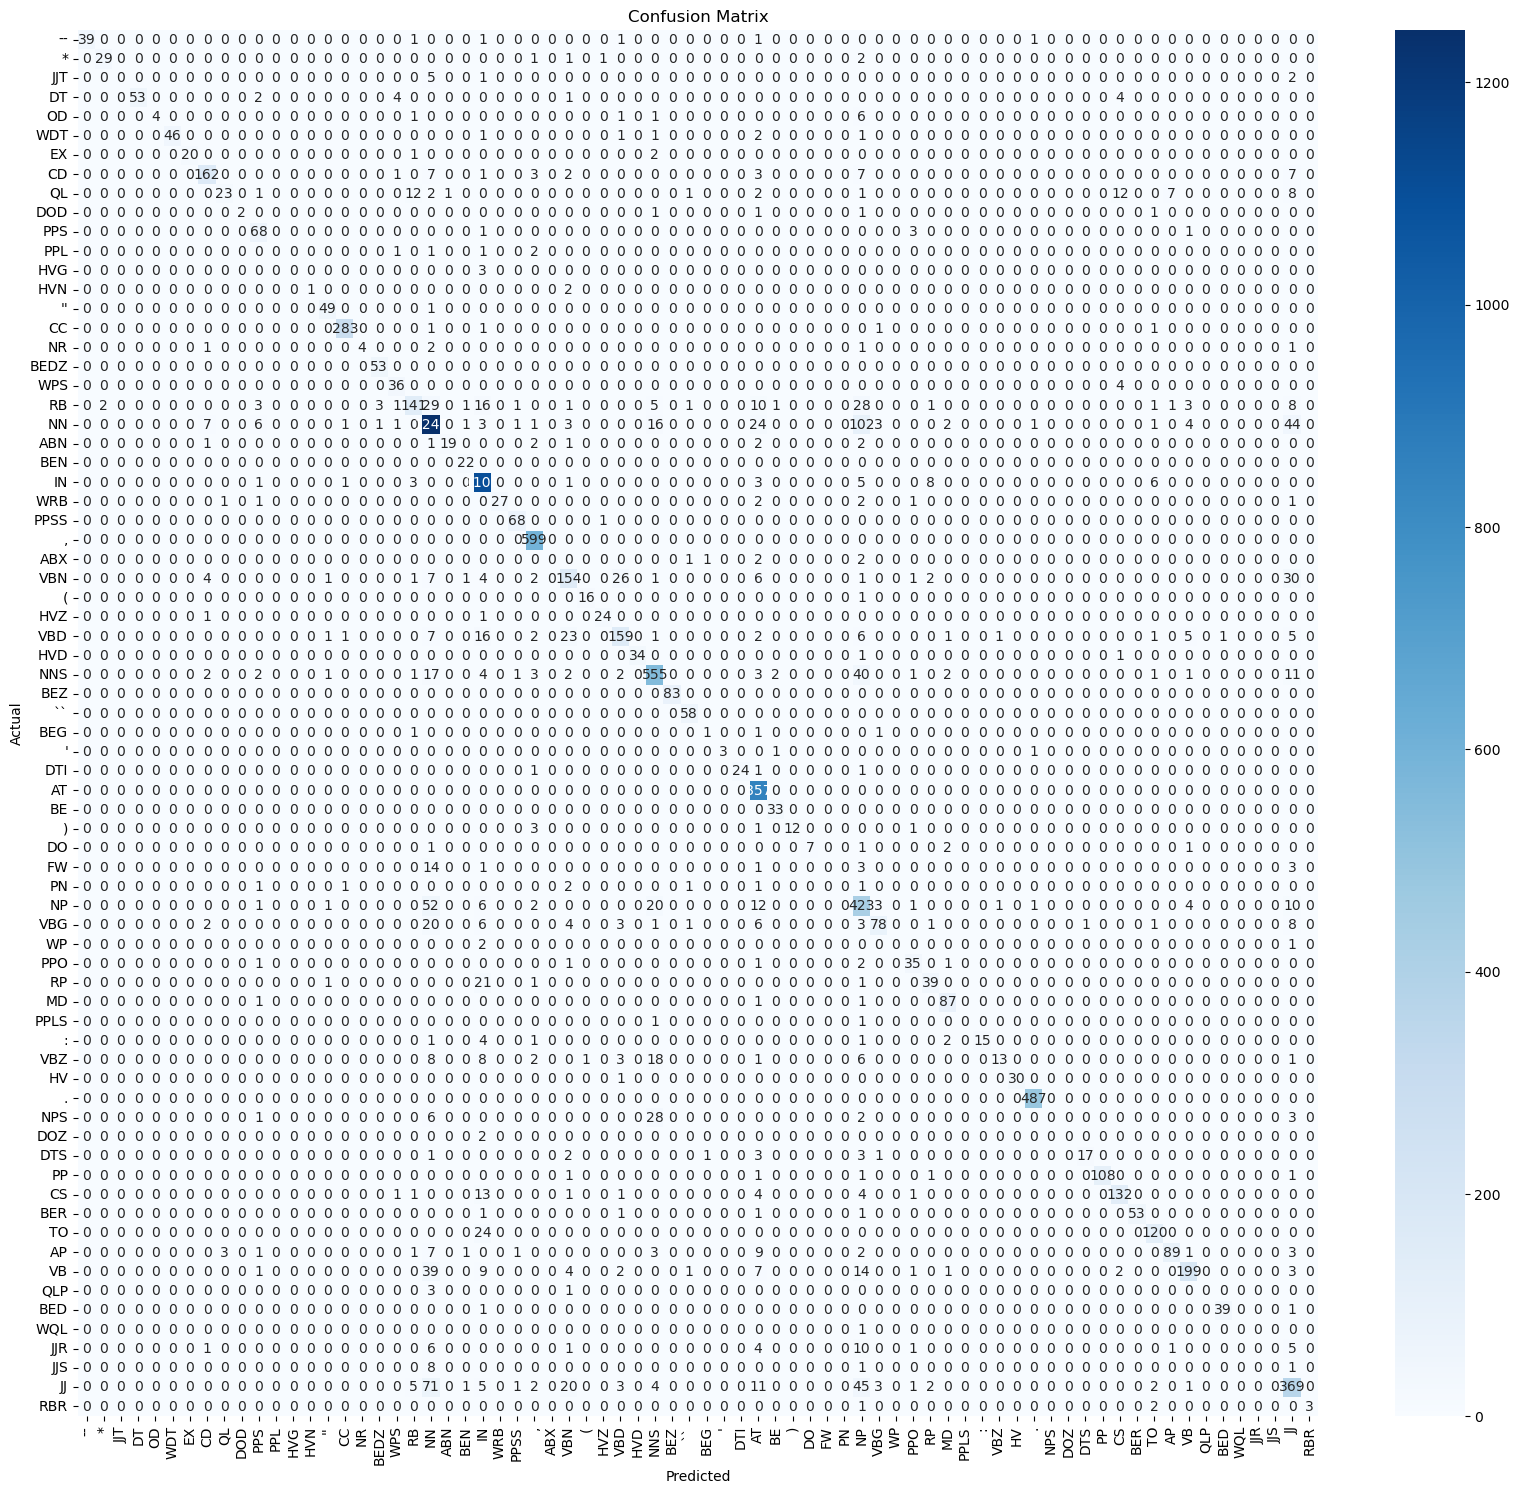

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

unique_tags = set(tag for pair in true_predicted_dict.keys() for tag in pair)
conf_matrix = np.zeros((len(unique_tags), len(unique_tags)))
for i, actual_tag in enumerate(unique_tags):
    for j, predicted_tag in enumerate(unique_tags):
        conf_matrix[i, j] = true_predicted_dict.get((actual_tag, predicted_tag), 0)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(20, 18))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=unique_tags, yticklabels=unique_tags)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [52]:
print("Results of part B")
print("known words error rate:")
print(0.0704399684933048)
print("unknown words error rate:")
print(0.743455497382199)
print("total error rate is:") 
print(0.14731386424798165)
print()
print("Results of part C")
print("known words error rate:")
print(0.2214470574997187)
print("unknown words error rate:")
print(0.787085514834206)
print("total error rate is:") 
print(0.286056015150005)
print()
print("Results of part D")
print("known words error rate:")
print(0.14448070214920672)
print("unknown words error rate:")
print(0.712914485165794)
print("total error rate is:") 
print(0.20940895046347052)
print()
print("Results of part E - ii")
print("known words error rate:")
print(0.17145899893503724)
print("unknown words error rate:")
print(0.40771175726927944)
print("total error rate is:") 
print(0.2087112528655437)
print()
print("Results of part E - iii")
print("known words error rate:")
print(0.11714589989350377)
print("unknown words error rate:")
print(0.3710493046776233)
print("total error rate is:") 
print(0.1571813017043756)

Results of part B
known words error rate:
0.0704399684933048
unknown words error rate:
0.743455497382199
total error rate is:
0.14731386424798165

Results of part C
known words error rate:
0.2214470574997187
unknown words error rate:
0.787085514834206
total error rate is:
0.286056015150005

Results of part D
known words error rate:
0.14448070214920672
unknown words error rate:
0.712914485165794
total error rate is:
0.20940895046347052

Results of part E - ii
known words error rate:
0.17145899893503724
unknown words error rate:
0.40771175726927944
total error rate is:
0.2087112528655437

Results of part E - iii
known words error rate:
0.11714589989350377
unknown words error rate:
0.3710493046776233
total error rate is:
0.1571813017043756
